<a href="https://colab.research.google.com/github/henrya2/MitsubaPlayground/blob/main/Gradient_based_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mitsuba

!rm scenes.zip
!wget https://rgl.s3.eu-central-1.amazonaws.com/scenes/tutorials/scenes.zip

# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("./scenes.zip", 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(
        path="../scenes/")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 104.1 MB/s eta 0:00:00
rm: cannot remove 'scenes.zip': No such file or directory
--2023-10-22 06:20:19--  https://rgl.s3.eu-central-1.amazonaws.com/scenes/tutorials/scenes.zip
Resolving rgl.s3.eu-central-1.amazonaws.com (rgl.s3.eu-central-1.amazonaws.com)... 52.219.72.116, 52.219.170.130, 52.219.170.10, ...
Connecting to rgl.s3.eu-central-1.amazonaws.com (rgl.s3.eu-central-1.amazonaws.com)|52.219.72.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9765095 (9.3M) [application/zip]
Saving to: ‘scenes.zip’

scenes.zip          100%[===================>]   9.31M  9.24MB/s    in 1.0s    

2023-10-22 06:20:21 (9.24 MB/s) - ‘scenes.zip’ saved [9765095/9765095]



In [2]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

In [3]:
scene = mi.load_file('../scenes/cbox.xml', res=128, integrator='prb')

In [4]:
image_ref = mi.render(scene, spp=512)

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [5]:
params = mi.traverse(scene)

key = 'red.reflectance.value'

# Save the original value
param_ref = mi.Color3f(params[key])

# Set another color value and update the scene
params[key] = mi.Color3f(0.01, 0.2, 0.9)
params.update();

In [6]:
image_init = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [7]:
opt = mi.ad.Adam(lr=0.05)
opt[key] = params[key]
params.update(opt);

In [8]:
def mse(image):
    return dr.mean(dr.sqr(image - image_ref))

In [9]:
iteration_count = 50

In [10]:
errors = []
for it in range(iteration_count):
    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params, spp=4)

    # Evaluate the objective function from the current rendered image
    loss = mse(image)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    opt[key] = dr.clamp(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    # Track the difference between the current color and the true value
    err_ref = dr.sum(dr.sqr(param_ref - params[key]))
    print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
    errors.append(err_ref)
print('\nOptimization complete.')

Iteration 49: parameter error = 0.001432
Optimization complete.


In [11]:
image_final = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_final)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

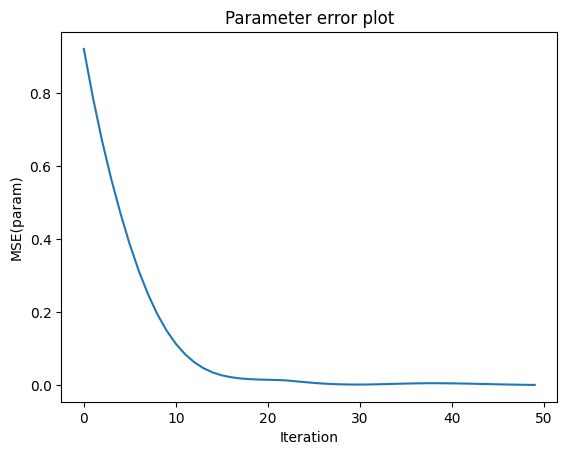

In [12]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
plt.show()